# Visualize feature maps with ResNet-18, PyTorch

Feature maps are the output we get after applying a group of filters to the previous layer's input which we pass to the next layer. Each layer applies some filters and generates feature maps. Filters are able to extract information like Edges, Texture, Patterns, Parts of Objects, etc.

Feature maps help to find out what features my model was focusing on or which filters my model applied. Feature maps help us to understand deep neural networks a little better.


[Reference](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.12.1+cu102
Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# print(torch.cuda.memory_summary())
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Define transformations to be applied to input image(s)-
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.0, std = 1.0)
    ]
)

In [7]:
# Load pre-trained ResNet-50 model-
# model = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
# Saved to /home/arjun/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

Resnet-18 CNN architecture has Conv2d, BatchNorm2d, ReLU, etc. as layers. But we are interested in checking only the feature maps within ```Conv2d``` because this is the layer where the filters are being applied. Therefore, we extract the ```Conv2d``` layers and store them in a list and also extract its corresponding parameters and store them in a list as well.

In [8]:
# Save conv layer weights as Python3 list-
model_conv_wts = []

# Retrieve all model children as Python3 list-
conv_layers = []

model_children = list(model.children())

In [9]:
counter = 0

# While extracting conv layers, do not store skip connections!
for i in range(len(list(model.children()))):
    # if type(model_children[i]) == nn.Conv2d and model_children[i].kernel_size != (1, 1):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_conv_wts.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                # if type(child) == nn.Conv2d and child.kernel_size != (1, 1):
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_conv_wts.append(child.weight)
                    conv_layers.append(child)

In [10]:
print(f"Total # of conv layers = {counter}")

Total # of conv layers = 17


In [11]:
# Sanity checks-
conv_layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_siz

In [12]:
# Input image-
image = Image.open(str("/home/arjun/Pictures/red-jupiter-ncscfkxxhi1a8t7p.jpg"))
image.size

(1920, 1200)

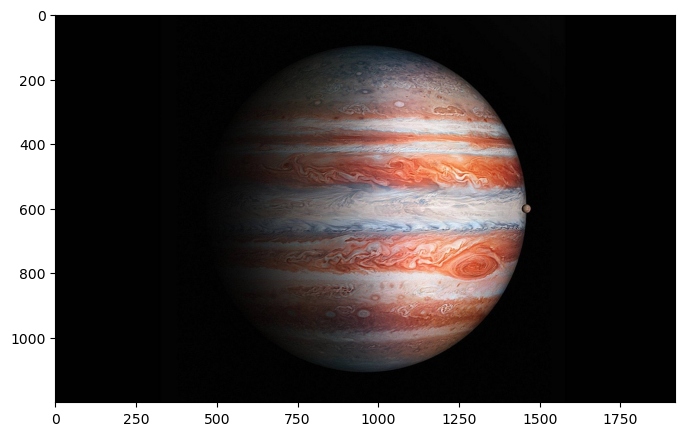

In [13]:
plt.figure(figsize = (8, 7))
plt.imshow(image)
plt.show()

In [14]:
# Apply image transformation, add batch size, move to GPU (if any)-
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


#### Generate feature maps

Pass the input image to each conv layer and append its output and layer name to ```outputs[]``` and ```names[]``` lists.

In [15]:
outputs, names = list(), list()

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

In [16]:
print(f"# of feature maps = {len(outputs)}")
for feature_map in outputs:
    print(feature_map.shape)

# of feature maps = 17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [17]:
# Convert 3D tensor to 2D and sum the same element of every channel-
processed = []

for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale /= feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

In [18]:
print(f"number of processed layers = {len(processed)}")

number of processed layers = 17


In [19]:
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


In [20]:
for i in range(len(processed)):
    print(f"i = {i}, processed[{i}].shape = {processed[i].shape}")
    

i = 0, processed[0].shape = (112, 112)
i = 1, processed[1].shape = (112, 112)
i = 2, processed[2].shape = (112, 112)
i = 3, processed[3].shape = (112, 112)
i = 4, processed[4].shape = (112, 112)
i = 5, processed[5].shape = (56, 56)
i = 6, processed[6].shape = (56, 56)
i = 7, processed[7].shape = (56, 56)
i = 8, processed[8].shape = (56, 56)
i = 9, processed[9].shape = (28, 28)
i = 10, processed[10].shape = (28, 28)
i = 11, processed[11].shape = (28, 28)
i = 12, processed[12].shape = (28, 28)
i = 13, processed[13].shape = (14, 14)
i = 14, processed[14].shape = (14, 14)
i = 15, processed[15].shape = (14, 14)
i = 16, processed[16].shape = (14, 14)


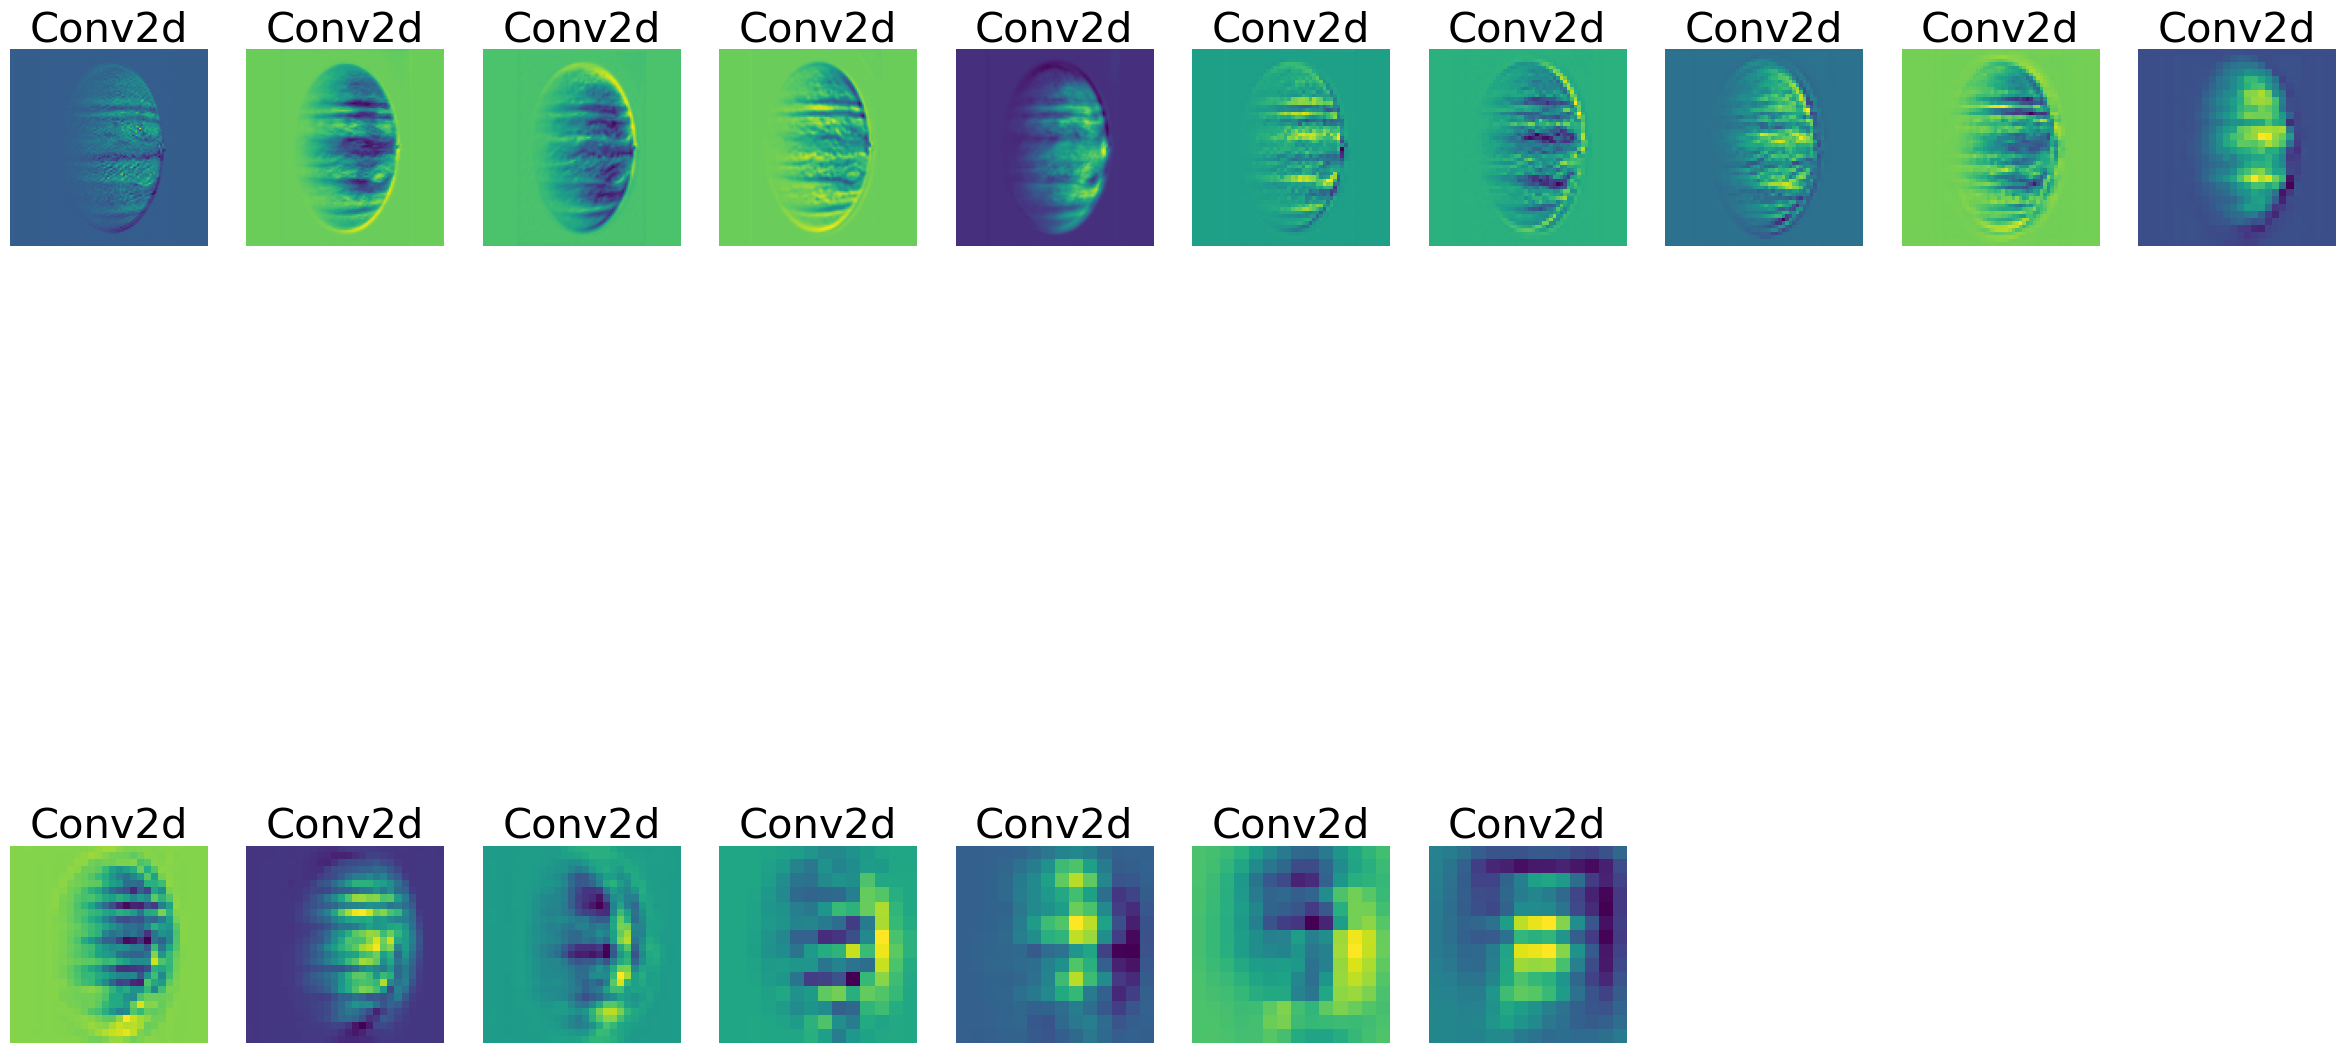

In [21]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 10, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize = 30)
    # fig.subplots_adjust(hspace = 0.2)

# plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
plt.show()